Antaget dataformat:

Local Time | Open | High | Low | Close | Volume | Name

Dollars-bar funktionen skal indeholde:

* Tilføj ny 'Mean' kolonne, som er udregnes
$$
\begin{align*}
    \text{Mean_HL} = \frac{\text{High} + \text{Low}}{2}
\end{align*}
$$

* Tilføj variablen 'Dollarbar_cap', som er $\text{DollarBar_cap} = max(\text{High}) \cdot max(\text{volume})$ skal rundes op til nærmeste million

* Tilføj variablen 'Total_transaction' som er $\text{Total_transaction}=\text{Rest_transaction}$ udenfor loop, og $\text{Total_transaction}=\text{Total_transaction}+\text{Volume}$ inde i loop.

* Tilføj variablen 'Rest_volume', som er $\text{Rest_transaction} = \text{Total_transaction} - \text{Dollarbar_cap}$, med start værdi 0, og kun når 'Total_transaction' > DollarBar_cap

* Tilføj vairablen 'Mean_OC', som er $\text{Mean_OC} = \frac{\text{Open} + \text{Close}}{2}$

* Tilføj variablen 'High_list' and 'Low_list', som skal append 'High' og 'Low' og når Dollarbar_cap er nået, så tage max og min af listen




start den førstes variable 'open' til 'open' og sæt 'close til den sidste rækkes open og close middelværdi (Mean_OC[1])
start den næste 'open' med Mean_OC[1] og close med Mean_OC[2]




Gem variable

* 'Dato' skal være slut Dato
* 'Open' fra 'Open' i starten ellers 'Mean_OC'
* 'High' og 'Low' fra HL_list, hvor der er taget min og max
* 'Close' fra 'Mean_OC'
* 'Type' fra 'type' i for loop variable 
* 'Volume' som er Dollarbar_cap


Funktionen virker nok ikke helt optimalt i det special tilfælde, hvor vi skal lave en dollarsbar på den sidste observation i aktie data'et. Som funktionen er nu, så vil den sidste dollarsbar være "rest", og her kan vi lægge under Dollarsbar_cap, men også over, hvilket jeg ikke er sikker på om det er okay.

Index driller, men ved ikke om det er vigtigt.

In [92]:
## Read data

import matplotlib
import pandas as pd
import numpy as np
import time
import os as os


os.chdir(r"C:\Users\Bruger\Documents\Google_Drev_data\SwissData")
date_cols = ['CET']
df = pd.read_csv('IndexDataHour.txt', index_col=None, parse_dates=date_cols, engine='python')
df_sub = df.iloc[0:2000000,:]

In [70]:
import math
import numpy as np


def roundup(x, k):
    return int(math.ceil(x / k)) * k


Value = []
for name in pd.unique(df['Name']):
    x = np.max(df[df['Name'] == name]['High'])*np.max(df[df['Name'] == name]['Volume'])
    print(x)
    Value.append(len(str(int(x/100))))

roundup_df = pd.DataFrame({'Name' : pd.unique(df['Name']), 'Value' : Value})
roundup_df

2053936316921.9983
3515884858276.1875
531177335956.39325
1357174006492.8555
474144566744.3967


,Name,Value
0,DAX,11
1,HK,11
2,S&P,10
3,NASDAQ,11
4,FTSE,10


In [39]:
df

,Open,High,Low,Close,Volume,Name,Type,CET,Year,Month,Day,Hour,Minute
0,12926.279,12946.780,12906.280,12920.279,2.383000e+07,DAX,Index,2018-01-02 08:00:00,2018,1,2,8,0
1,12916.980,12919.280,12786.780,12816.480,5.839000e+07,DAX,Index,2018-01-02 09:00:00,2018,1,2,9,0
2,12816.479,12843.779,12746.979,12765.279,4.194000e+07,DAX,Index,2018-01-02 10:00:00,2018,1,2,10,0
3,12766.279,12829.979,12765.479,12815.780,2.888501e+07,DAX,Index,2018-01-02 11:00:00,2018,1,2,11,0
4,12815.979,12839.279,12803.279,12821.480,2.522000e+07,DAX,Index,2018-01-02 12:00:00,2018,1,2,12,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
114601,7534.211,7556.597,7525.397,7542.373,2.226400e+06,FTSE,Index,2022-04-29 17:00:00,2022,4,29,17,0
114602,7542.123,7542.614,7502.423,7504.901,1.035200e+06,FTSE,Index,2022-04-29 18:00:00,2022,4,29,18,0
114603,7504.651,7524.649,7501.210,7503.430,1.150400e+06,FTSE,Index,2022-04-29 19:00:00,2022,4,29,19,0
114604,7503.198,7506.286,7476.474,7482.211,1.129200e+06,FTSE,Index,2022-04-29 20:00:00,2022,4,29,20,0


In [88]:


def dollarbar(df, time_unit, roundup_df):
    if isinstance(df, pd.DataFrame):
        
        ## Create empty dataframe
        df_Dollarbar = pd.DataFrame({'CPHTime' : [], 'Period' : [], 'Open' : [], 'Low' : [], 'High' : [], 
                                      'Close' : [], 'Volume' : [], 'Monetary_Volume' : [], 'Name' : [], 'Type' : []})
        
        for name in pd.unique(df['Name']):
    
            df_type = df[df['Name'] == name]
            df_type = df_type.reset_index(drop=True)
            Rest_transaction = 0
            Total_transaction = 0
            Type = df_type['Type'][0]
    
            ## Empty lists
            Time_list = []
            Year_list = []
            Month_list = []
            Day_list = []
            Open_list = []
            Low_list = []
            High_list = []
            Close_list = []
            Volume_list = []
            HL_list = []
            Period_list = []
    
            ## support vairables
            Volume_help_list = []
            iter_since_dollarbar = 0
    
            ## Dollarsbar cap
            max_High = np.max(df_type['High'])
            max_Volume = np.max(df_type['Volume'])
            Dollarbar_cap = roundup(max_High * max_Volume, 10**roundup_df[roundup_df['Name'] == 'DAX']['Value'].item())
    
            ## First value in Open
            Open_list.append(df_type['Open'][0])
    
            for n in np.arange(df_type.shape[0]):        
            
                Time = df_type['CET'][n]
                Year = df_type['Year'][n]
                Month = df_type['Month'][n]
                Day = df_type['Day'][n]
                Open = df_type['Open'][n]
                High = df_type['High'][n]
                Low = df_type['Low'][n]
                Close = df_type['Close'][n]
                Volume = df_type['Volume'][n]
        
                Mean_HL = np.mean([High, Low])
                HL_list.append(High)
                HL_list.append(Low)
        
                Total_transaction = Total_transaction + Mean_HL*Volume 
                Mean_OC = np.mean([Open, Close])
        
                Volume_help_list.append(Volume)
        
                iter_since_dollarbar += 1
            
                if n % 10000 == 0:
                    print(n)
        
                if Dollarbar_cap < Total_transaction:   #and df_type.shape[0] > n
            
                    Rest_transaction = Total_transaction - Dollarbar_cap
            
                    max_High = np.max(HL_list)
                    min_Low = np.min(HL_list)
            
                    p = (Dollarbar_cap - Total_transaction + Mean_HL*Volume)/(Mean_HL*Volume) ## andel af volume som skal med i denne dollarsbar
                    Volume_help_list[-1] = Volume*p
                    Sum_volume = np.sum(Volume_help_list)
            
                    ## Saving dollarbar values
                    Time_list.append(Time)
                    Year_list.append(Year)
                    Month_list.append(Month)
                    Day_list.append(Day)
                    Period_list.append(iter_since_dollarbar*time_unit)
                    Low_list.append(min_Low)
                    High_list.append(max_High)
                    Close_list.append(Mean_OC)
                    Volume_list.append(Sum_volume)
                    Open_list.append(Mean_OC)
                    
                    HL_list = []
            
                    Volume_help_list = []
                    Volume_help_list.append(Volume*(1-p)) ## andel af volume som skal med i næste dollarsbar
                    
                    Total_transaction = Rest_transaction
            
                    iter_since_dollarbar = 0
            
                if df_type.shape[0] == n+1 and iter_since_dollarbar == 0:
                
                    Sum_volume = Volume * (1-p)
                
                    Close_list.append(Close)
                    Time_list.append(Time)  ## Time bliver det samme, hvilket ik er godt
                    Year_list.append(Year)
                    Month_list.append(Month)
                    Day_list.append(Day)
                    Low_list.append(min_Low)
                    High_list.append(max_High)
                    Volume_list.append(Sum_volume)
            
                    df_dummy = pd.DataFrame({'CET' : Time_list, 'Year' : Year_list, 'Month' : Month_list, 'Day' : Day_list,
                                             'Period' : Period_list, 'Open' : Open_list, 'Low' : Low_list, 'High' : High_list, 
                                             'Close' : Close_list, 'Volume' : Volume_list, 
                                             'Monetary_Volume' : Dollarbar_cap, 'Name' : name, 'Type' : Type})
                    df_Dollarbar = pd.concat([df_Dollarbar,df_dummy.iloc[:-1,:]])
            
                if df_type.shape[0] == n+1 and iter_since_dollarbar > 0:
            
                    max_High = np.max(HL_list)
                    min_Low = np.min(HL_list)
            
                    Sum_volume = np.sum(Volume_help_list)
            
                    ## Saving dollarbar values
                    Time_list.append(Time)
                    Year_list.append(Year)
                    Month_list.append(Month)
                    Day_list.append(Day)
                    Period_list.append(iter_since_dollarbar*time_unit)
                    Low_list.append(min_Low)
                    High_list.append(max_High)
                    Close_list.append(Mean_HL)
                    Volume_list.append(Sum_volume)
            
                    df_dummy = pd.DataFrame({'CET' : Time_list, 'Year' : Year_list, 'Month' : Month_list, 'Day' : Day_list,
                                             'Period' : Period_list, 'Open' : Open_list, 'Low' : Low_list, 'High' : High_list, 
                                             'Close' : Close_list, 'Volume' : Volume_list, 
                                             'Monetary_Volume' : Dollarbar_cap, 'Name' : name, 'Type' : Type})
                    df_dummy['Monetary_Volume'].iloc[-1] = Total_transaction
                    df_Dollarbar = pd.concat([df_Dollarbar,df_dummy])
        
        return df_Dollarbar
            
    else:
        print('Input need to be a Pandas DataFrame')
            




In [89]:

start=time.time()  # Start the time


## Running the function 
df_dollarbar = dollarbar(df, 1, roundup_df)
df_dollarbar = df_dollarbar.reset_index(drop=True)


# Print the time usage:
end = time.time()  # Stop the time
print(f"Time used: {(end-start):.1f} seconds")

0
10000
20000


C:\Users\Bruger\AppData\Local\Temp\ipykernel_13948\2225397274.py:140: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_dummy['Monetary_Volume'].iloc[-1] = Total_transaction


0
10000
0
10000
20000
0
10000
20000


C:\Users\Bruger\AppData\Local\Temp\ipykernel_13948\2225397274.py:140: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_dummy['Monetary_Volume'].iloc[-1] = Total_transaction


0
10000
20000
Time used: 22.5 seconds


C:\Users\Bruger\AppData\Local\Temp\ipykernel_13948\2225397274.py:140: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_dummy['Monetary_Volume'].iloc[-1] = Total_transaction


In [76]:
df_dollarbar[df_dollarbar['Name'] == 'DAX']
df_dollarbar

,CPHTime,Period,Open,Low,High,Close,Volume,Monetary_Volume,Name,Type,Year,Month,Day
0,2018-01-02 12:00:00,5.0,12926.2790,12746.979,12946.780,12818.7295,1.635878e+08,2.100000e+12,DAX,Index,2018.0,1.0,2.0
1,2018-01-02 17:00:00,5.0,12818.7295,12793.979,12925.979,12876.5295,1.634154e+08,2.100000e+12,DAX,Index,2018.0,1.0,2.0
2,2018-01-03 11:00:00,8.0,12876.5295,12865.979,12949.979,12912.9800,1.627117e+08,2.100000e+12,DAX,Index,2018.0,1.0,3.0
3,2018-01-03 17:00:00,6.0,12912.9800,12909.280,13024.480,12983.1290,1.620420e+08,2.100000e+12,DAX,Index,2018.0,1.0,3.0
4,2018-01-04 10:00:00,7.0,12983.1290,12973.479,13121.980,13101.1290,1.610397e+08,2.100000e+12,DAX,Index,2018.0,1.0,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3515,2022-04-14 21:00:00,58.0,7558.7865,7531.303,7622.147,7601.6465,6.599417e+07,5.000000e+11,FTSE,Index,2022.0,4.0,14.0
3516,2022-04-22 09:00:00,78.0,7601.6465,7509.773,7656.590,7578.0600,6.574977e+07,5.000000e+11,FTSE,Index,2022.0,4.0,22.0
3517,2022-04-26 15:00:00,51.0,7578.0600,7336.984,7609.683,7432.9355,6.702680e+07,5.000000e+11,FTSE,Index,2022.0,4.0,26.0
3518,2022-04-29 09:00:00,63.0,7432.9355,7306.243,7580.320,7550.4330,6.709933e+07,5.000000e+11,FTSE,Index,2022.0,4.0,29.0


### More data

New data
* ROC-5: 5 days change of rate $\frac{\text{Close}_{new}}{\text{Close}_{5}}$
* ROC-10: 10 days change of rate $\frac{\text{Close}_{new}}{\text{Close}_{10}}$
* ROC-15: 15 days change of rate $\frac{\text{Close}_{new}}{\text{Close}_{15}}$
* ROC-20: 20 days change of rate $\frac{\text{Close}_{new}}{\text{Close}_{20}}$
* EMA-days: 10/50/200 days exponential moving average $\text{Close}_{new}\cdot\frac{\beta}{1+\text{Days}}+\text{EMA}_{old}\cdot(1-\frac{\beta}{1+\text{Days}})$

Formel used for EMA: https://www.investopedia.com/terms/e/ema.asp


In [93]:
def ROC(df, unit):
    if isinstance(df, pd.DataFrame):
        final_df = pd.DataFrame()
        for name in pd.unique(df['Name']):
            
            df_type = df[df['Name'] == name]
            
            close = df_type['Close']
            ROC_df = close.pct_change(periods=unit)
            
            final_df = pd.concat([final_df,ROC_df])
            
        final_df.replace(np.nan, 0, inplace = True)       
        return final_df.to_numpy().reshape(-1)
        
    else:
        print('Input need to be a Pandas DataFrame')

        

ROC_5 = ROC(df_dollarbar, 5)
ROC_10 = ROC(df_dollarbar, 10)
ROC_15 = ROC(df_dollarbar, 15)
ROC_20 = ROC(df_dollarbar, 20)
df_dummy = pd.DataFrame({'ROC-5' : ROC_5, 'ROC-10' : ROC_10,
                        'ROC-15' : ROC_15, 'ROC-20' : ROC_20})
df_dollarbar = pd.concat([df_dollarbar,df_dummy], axis = 1)
  

def EMA(df, days, smoothing = 2):
    if isinstance(df, pd.DataFrame):
        final_list = []
        k = smoothing / (days + 1)
        
        for name in pd.unique(df['Name']):
            
            df_type = df[df['Name'] == name]
            df_type = df_type.reset_index(drop=True)
            
            EMA_list = [0]*days
            SMA = np.mean(df_type['Close'][0:days])
            EMA = SMA # Our first previous EMA
            
            for n in np.arange(days,df_type.shape[0]):
                
                close = df_type['Close'][n]
                EMA = close * k + EMA * (1-k)
                EMA_list.append(EMA)
                
                if n % 100000 == 0:
                    print(n)
            
            final_list = final_list + EMA_list
        
        return final_list
        
    else:
        print('Input need to be a Pandas DataFrame')

        

EMA_10 = EMA(df_dollarbar, 5)
EMA_50 = EMA(df_dollarbar, 10)
EMA_200 = EMA(df_dollarbar, 15)
df_dummy = pd.DataFrame({'EMA-5' : EMA_10, 'EMA-10' : EMA_50, 'EMA-15' : EMA_200})
df_dollarbar = pd.concat([df_dollarbar,df_dummy], axis = 1)

In [94]:
ROC_5 = ROC(df, 5)
ROC_10 = ROC(df, 10)
ROC_15 = ROC(df, 15)
ROC_20 = ROC(df, 20)
df_dummy = pd.DataFrame({'ROC-5' : ROC_5, 'ROC-10' : ROC_10,
                        'ROC-15' : ROC_15, 'ROC-20' : ROC_20})
df1 = pd.concat([df,df_dummy], axis = 1)

EMA_10 = EMA(df, 10)
EMA_50 = EMA(df, 50)
EMA_200 = EMA(df, 200)
df_dummy = pd.DataFrame({'EMA-10' : EMA_10, 'EMA-50' : EMA_50, 'EMA-200' : EMA_200})
df1 = pd.concat([df1,df_dummy], axis = 1)

In [96]:
df1[df1['Name'] == 'HK']

,Open,High,Low,Close,Volume,Name,Type,CET,Year,Month,Day,Hour,Minute,ROC-5,ROC-10,ROC-15,ROC-20,EMA-10,EMA-50,EMA-200
24739,30226.969,30346.969,30152.970,30320.970,3.003000e+06,HK,Index,2018-01-02 02:00:00,2018,1,2,2,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
24740,30321.969,30385.970,30288.969,30336.969,4.746000e+06,HK,Index,2018-01-02 03:00:00,2018,1,2,3,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
24741,30337.970,30425.969,30320.969,30412.969,2.817000e+06,HK,Index,2018-01-02 04:00:00,2018,1,2,4,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
24742,30411.969,30411.969,30411.969,30411.969,1.000000e+03,HK,Index,2018-01-02 05:00:00,2018,1,2,5,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
24743,30412.970,30475.970,30387.969,30437.970,2.806000e+06,HK,Index,2018-01-02 06:00:00,2018,1,2,6,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40487,20940.945,21016.696,20917.604,20979.498,3.425480e+05,HK,Index,2022-04-29 14:00:00,2022,4,29,14,0,-0.005904,0.044021,0.039966,0.038887,20829.718607,20348.535263,20680.843809
40488,20978.945,21149.292,20912.710,21098.451,5.152960e+05,HK,Index,2022-04-29 15:00:00,2022,4,29,15,0,0.000180,0.050123,0.051321,0.041094,20878.579042,20377.943723,20684.999105
40489,21098.610,21142.451,20909.710,20955.210,5.266000e+05,HK,Index,2022-04-29 16:00:00,2022,4,29,16,0,-0.003137,0.015203,0.046615,0.036130,20892.511944,20400.581617,20687.687771
40490,20954.763,21009.696,20897.157,20961.998,4.282340e+05,HK,Index,2022-04-29 17:00:00,2022,4,29,17,0,-0.001945,0.005295,0.049338,0.036663,20905.145772,20422.597945,20690.417226


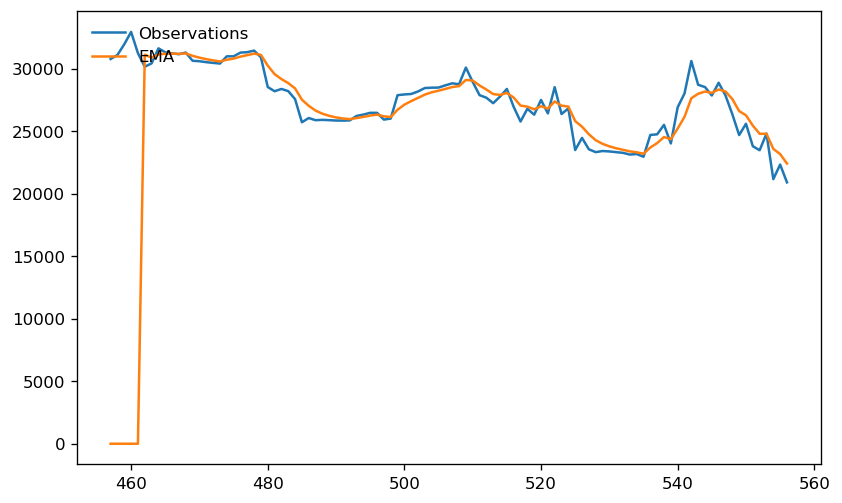

In [86]:
import matplotlib.pyplot as plt


df1 = df_dollarbar[df_dollarbar['Name'] == 'HK']

fig, ax = plt.subplots(figsize=(8, 5), dpi=120)
plt.plot(df1['Close'], label='Observations')
plt.plot(df1['EMA-5'], label='EMA')
ax.legend(loc='upper left', frameon=False)
plt.show()

### Saving data

In [97]:
#df_dollarbar.to_csv('DollarbarData.txt', index = False, header=True)
df1.to_csv('IndexDataHour_v1.txt', index = False, header=True)